In [1]:
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import chain
from sklearn.linear_model import LinearRegression
import os
import logging

In [2]:
from utils.DetectionTools import merge_close_points, get_detected_intervals
from utils.OutlierUtils import left_derivatives, get_region, remove_outliers_by_region, sanitize_response_name


In [3]:
concentrations = None
response = '' # Change this to select the response column
dataset_name = '*'
path_to_data = f'../data/ICP-MS/{dataset_name}.csv'
output_path = '../output'

In [4]:
# Parameters
concentrations = [1, 2, 3, 4, 5]
dataset_name = "Example_processed_data_020525_after_25000"
path_to_data = "../data/ICP-MS/Example_processed_data_020525_after_25000.csv"
response = "Pt"
output_path = "../output/Example_processed_data_020525_after_25000"


# Indicate the path to your data file here

In [5]:
# Import data
df = pd.read_csv(path_to_data)
t = df['Time']
response_data = df[response] if response else df.iloc[:, 1]  # Default to the second column if no response specified
df

,Time,Pt
0,25000.121,180.001134
1,25000.272,130.000592
2,25000.422,70.000171
3,25000.573,160.000896
4,25000.723,70.000171
...,...,...
4972,25747.920,100.000350
4973,25748.070,100.000350
4974,25748.221,160.000896
4975,25748.371,80.000224


In [6]:
safe_name = sanitize_response_name(response)
figure_dir = f'{output_path}/figures/{safe_name}'
os.makedirs(figure_dir, exist_ok=True)

In [7]:
# Identifying shifts with k-means
X = collections.deque(t)
Y = collections.deque(response_data)

In [8]:
# Normalize time
df['Time'] = df['Time'] - df['Time'].min()
df = df.loc[:, df.columns.intersection(['Time',f'{response}'])]
df_response_idxMax = df.idxmax()[response]
df = df.iloc[:df_response_idxMax+1]

df

,Time,Pt
0,0.000,180.001134
1,0.151,130.000592
2,0.301,70.000171
3,0.452,160.000896
4,0.602,70.000171
...,...,...
4503,677.261,50689.771590
4504,677.411,55909.190650
4505,677.561,63581.175640
4506,677.712,65509.860360


In [9]:
%matplotlib qt

clicked_coordinates = None # Variable to store the click location
left_derivatives_df = left_derivatives(df['Time'].to_numpy(), df[response].to_numpy())


def onclick(event):
    global clicked_coordinates # Declare it global to modify the outside variable
    if event.xdata is not None and event.ydata is not None:
        clicked_coordinates = (event.xdata, event.ydata)
        logging.info(f"Clicked at data coordinates: x={event.xdata}, y={event.ydata}")
        plt.close(fig) # Close the window

    else:
        logging.info("Click was outside the plot area.")

fig, ax1 = plt.subplots(figsize=(18, 12), layout='constrained') # Increased figure size for clarity
plt.scatter(df['Time'], df[response])

# Save derivative and data pllot
plt.savefig(f'{output_path}/{dataset_name}/Derivative-Data-Plot', bbox_inches='tight',dpi=300)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Now your loop can run while the plot is interactive
logging.info("Waiting for a click...")
start_time = time.time()
timeout_seconds = 1000 # Your desired timeout

while True:
    if clicked_coordinates:
        logging.info(f"Click detected at: {clicked_coordinates}")
        break
    if (time.time() - start_time) > timeout_seconds:
        logging.info('Timed out. No click detected within the specified time.')
        break
    plt.pause(0.1) # Process GUI events for a short period
                   # This is crucial for interactive mode to work
plt.ioff() # Turn off interactive mode
plt.show() # Keep the plot open until manually closed after the loop

INFO: Waiting for a click...


INFO: Clicked at data coordinates: x=211.25311294591708, y=266.7761456865501


INFO: Click detected at: (211.25311294591708, 266.7761456865501)


In [10]:
%matplotlib inline

# After the window is closed, you can access the stored coordinates
if clicked_coordinates:
    logging.info(f"The final stored coordinates are: {clicked_coordinates}")
else:
    logging.info("No valid click was registered before the window closed.")

first_region = (np.array([0]).astype(float)[0], clicked_coordinates[0])
first_region

INFO: The final stored coordinates are: (211.25311294591708, 266.7761456865501)


(0.0, 211.25311294591708)

In [11]:
# Get left derivatives
left_derivatieves_df = left_derivatives_df[left_derivatives_df['Time'] > first_region[1]]
left_derivatives_df.set_index(['Time'], inplace=True)
left_derivatives_df

,Y,Left_Derivative
Time,,
0.000,180.001134,NaN
0.151,130.000592,-331.129421
0.301,70.000171,-400.002800
0.452,160.000896,596.031288
0.602,70.000171,-600.004830
...,...,...
677.261,50689.771590,-30842.624635
677.411,55909.190650,34796.127067
677.561,63581.175640,51146.566600


In [12]:
# Define the first region
mask1 = (left_derivatives_df['Left_Derivative'] > left_derivatives_df['Y'])
shifts = left_derivatives_df[mask1]
mask2 = (shifts.index > first_region[1])
shifts = shifts[mask2]

shifts = list(shifts.index)

shifts

[211.31500000000233,
 211.46600000000035,
 211.6160000000018,
 276.4390000000021,
 290.57700000000114,
 342.46600000000035,
 356.45300000000134,
 357.65599999999904,
 357.8070000000007,
 357.95700000000215,
 358.10699999999997,
 358.25800000000163,
 358.40799999999945,
 359.01000000000204,
 521.8950000000004,
 522.1959999999999,
 522.4969999999994,
 522.9480000000003,
 523.0980000000018,
 523.2489999999998,
 523.3990000000013,
 523.5499999999993,
 523.8500000000022]

In [13]:
detected_intervals = get_detected_intervals(shifts)
detected_intervals.append((first_region[1], detected_intervals[0][0]))
detected_intervals.append((first_region[0], first_region[1])) # Add the first region
detected_intervals = sorted(detected_intervals)

detected_intervals.append((detected_intervals[-1][1], df['Time'].max())) # Add the last region
detected_intervals


[(0.0, 211.25311294591708),
 (211.25311294591708, 211.31500000000233),
 (211.31500000000233, 211.46600000000035),
 (211.46600000000035, 211.6160000000018),
 (211.6160000000018, 276.4390000000021),
 (276.4390000000021, 290.57700000000114),
 (290.57700000000114, 342.46600000000035),
 (342.46600000000035, 356.45300000000134),
 (356.45300000000134, 357.65599999999904),
 (357.65599999999904, 357.8070000000007),
 (357.8070000000007, 357.95700000000215),
 (357.95700000000215, 358.10699999999997),
 (358.10699999999997, 358.25800000000163),
 (358.25800000000163, 358.40799999999945),
 (358.40799999999945, 359.01000000000204),
 (359.01000000000204, 521.8950000000004),
 (521.8950000000004, 522.1959999999999),
 (522.1959999999999, 522.4969999999994),
 (522.4969999999994, 522.9480000000003),
 (522.9480000000003, 523.0980000000018),
 (523.0980000000018, 523.2489999999998),
 (523.2489999999998, 523.3990000000013),
 (523.3990000000013, 523.5499999999993),
 (523.5499999999993, 523.8500000000022),
 (523.

# Select a p value here

In [14]:
p = 70 # Change this to select the p value for merging close points

In [15]:
merged_points = merge_close_points(df=df, regions=detected_intervals, p=p, response=response)
merged_points_list = sorted(list(set(tuple(chain.from_iterable(merged_points)))))
merged_points

Merged tiny region (211.25311294591708, 211.31500000000233) with previous region (0.0, 211.25311294591708) -> (0.0, 211.31500000000233)
Merged tiny region (211.31500000000233, 211.46600000000035) with previous region (0.0, 211.31500000000233) -> (0.0, 211.46600000000035)
Merged tiny region (211.46600000000035, 211.6160000000018) with previous region (0.0, 211.46600000000035) -> (0.0, 211.6160000000018)
Merged tiny region (356.45300000000134, 357.65599999999904) with previous region (342.46600000000035, 356.45300000000134) -> (342.46600000000035, 357.65599999999904)
Merged tiny region (357.65599999999904, 357.8070000000007) with previous region (342.46600000000035, 357.65599999999904) -> (342.46600000000035, 357.8070000000007)
Merged tiny region (357.8070000000007, 357.95700000000215) with previous region (342.46600000000035, 357.8070000000007) -> (342.46600000000035, 357.95700000000215)
Merged tiny region (357.95700000000215, 358.10699999999997) with previous region (342.46600000000035

[(0.0, 211.6160000000018),
 (211.6160000000018, 359.01000000000204),
 (359.01000000000204, 523.8500000000022),
 (523.8500000000022, 677.862000000001)]

## Final Plot

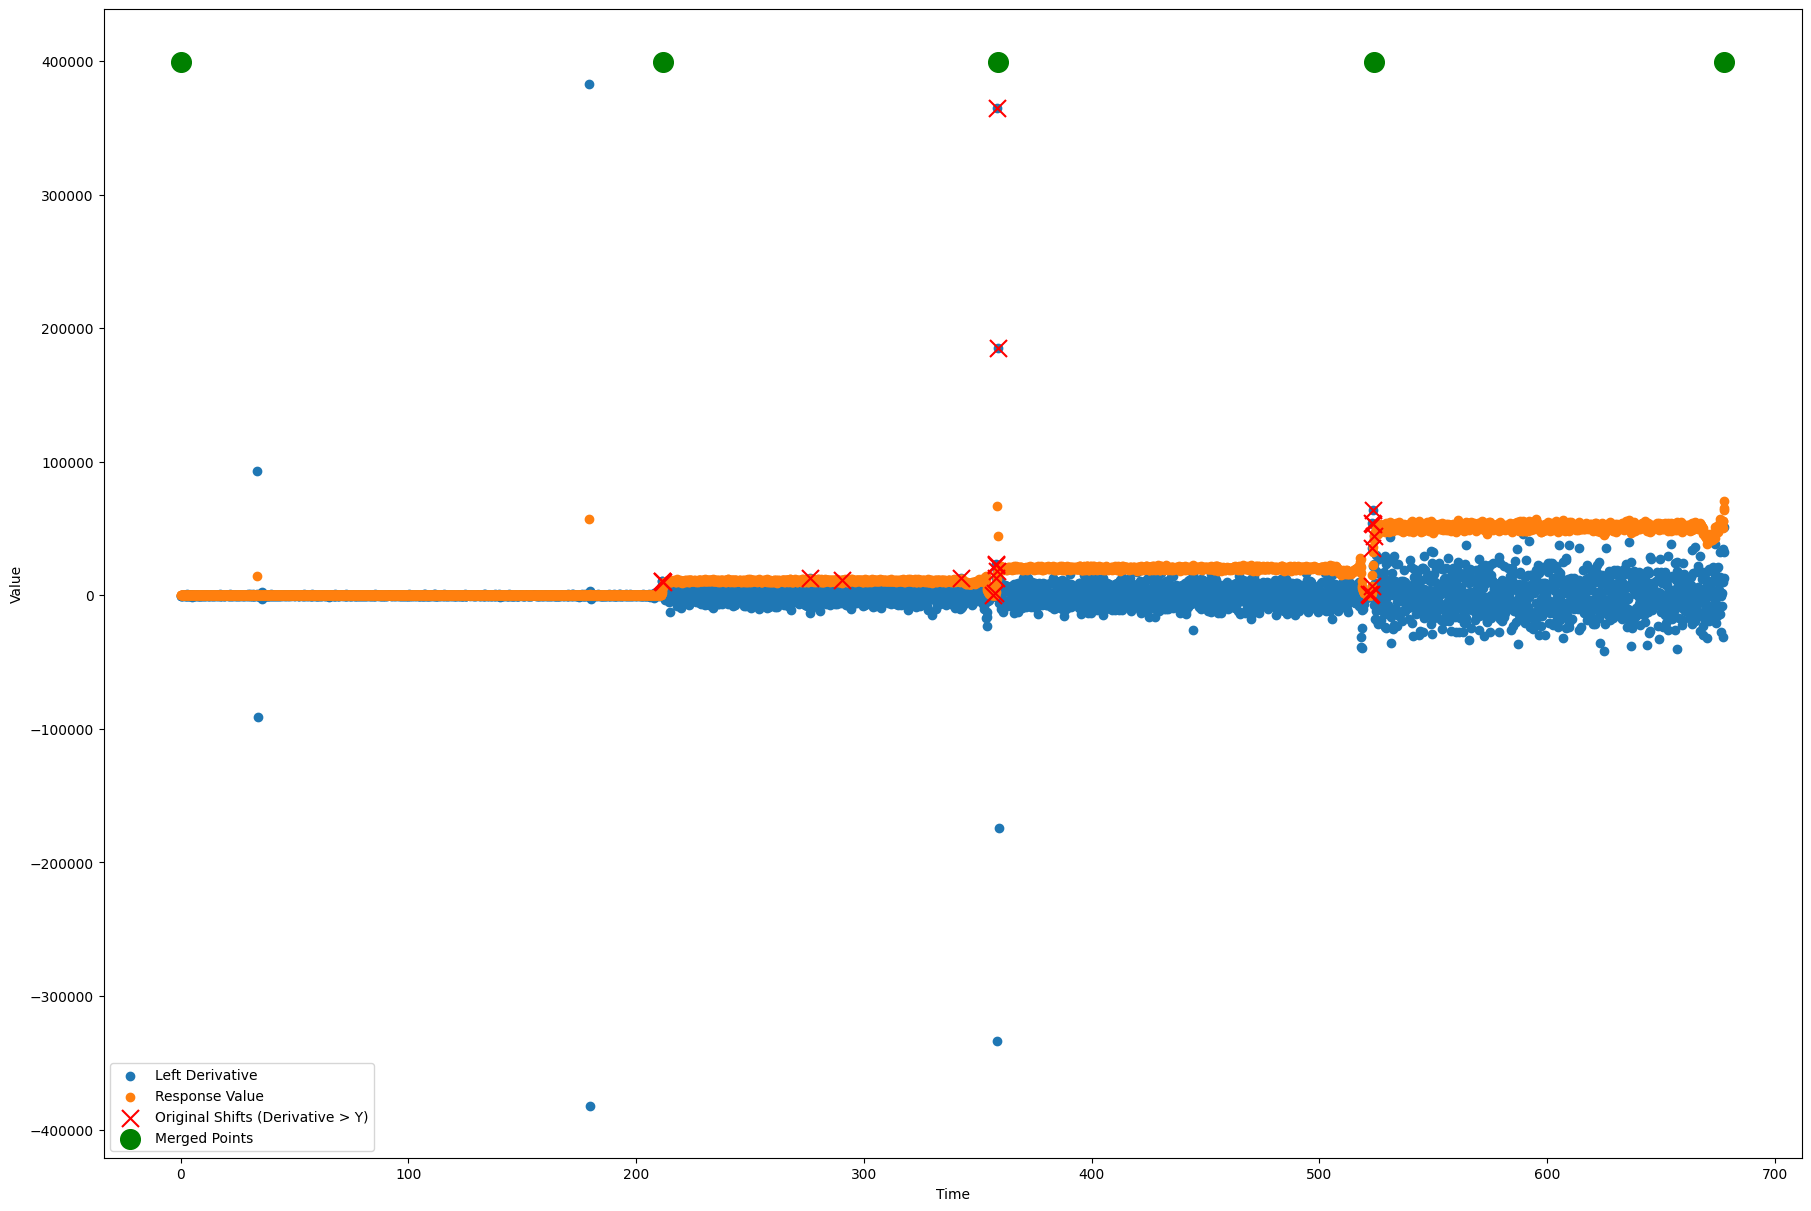

In [16]:
fig, ax1 = plt.subplots(figsize=(18, 12), layout='constrained')

# Plot original data and derivatives
ax1.scatter(left_derivatives_df.index, left_derivatives_df['Left_Derivative'], label='Left Derivative')
ax1.scatter(df['Time'], df[response], label='Response Value')

# Plot the original 'shifts' as red 'x' marks
ax1.scatter(shifts,
            left_derivatives_df.loc[shifts, 'Left_Derivative'],
            marker='x', color='red', s=150, zorder=4, label='Original Shifts (Derivative > Y)')


# Add the merged points to the plot as green circles
ax1.scatter(merged_points_list, [ax1.get_ylim()[1] * 0.95] * len(merged_points_list),
            marker='o', color='green', s=200, zorder=5, label='Merged Points') # Plot high up to be visible'

ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.legend()
plt.savefig(f'{figure_dir}/Regional-Final.png',bbox_inches='tight',dpi=300)
plt.show()


get_region called with t0=0.0, tf=211.25311294591708. Filtered DataFrame shape: (1405, 2)
get_region called with t0=15.0, tf=196.25311294591708. Filtered DataFrame shape: (1205, 2)
get_region called with t0=211.25311294591708, tf=211.31500000000233. Filtered DataFrame shape: (1, 2)
get_region called with t0=226.25311294591708, tf=196.31500000000233. Filtered DataFrame shape: (0, 2)
get_region called with t0=211.31500000000233, tf=211.46600000000035. Filtered DataFrame shape: (2, 2)
get_region called with t0=226.31500000000233, tf=196.46600000000035. Filtered DataFrame shape: (0, 2)
get_region called with t0=211.46600000000035, tf=211.6160000000018. Filtered DataFrame shape: (2, 2)
get_region called with t0=226.46600000000035, tf=196.6160000000018. Filtered DataFrame shape: (0, 2)
get_region called with t0=211.6160000000018, tf=276.4390000000021. Filtered DataFrame shape: (432, 2)
get_region called with t0=226.6160000000018, tf=261.4390000000021. Filtered DataFrame shape: (232, 2)
get_r

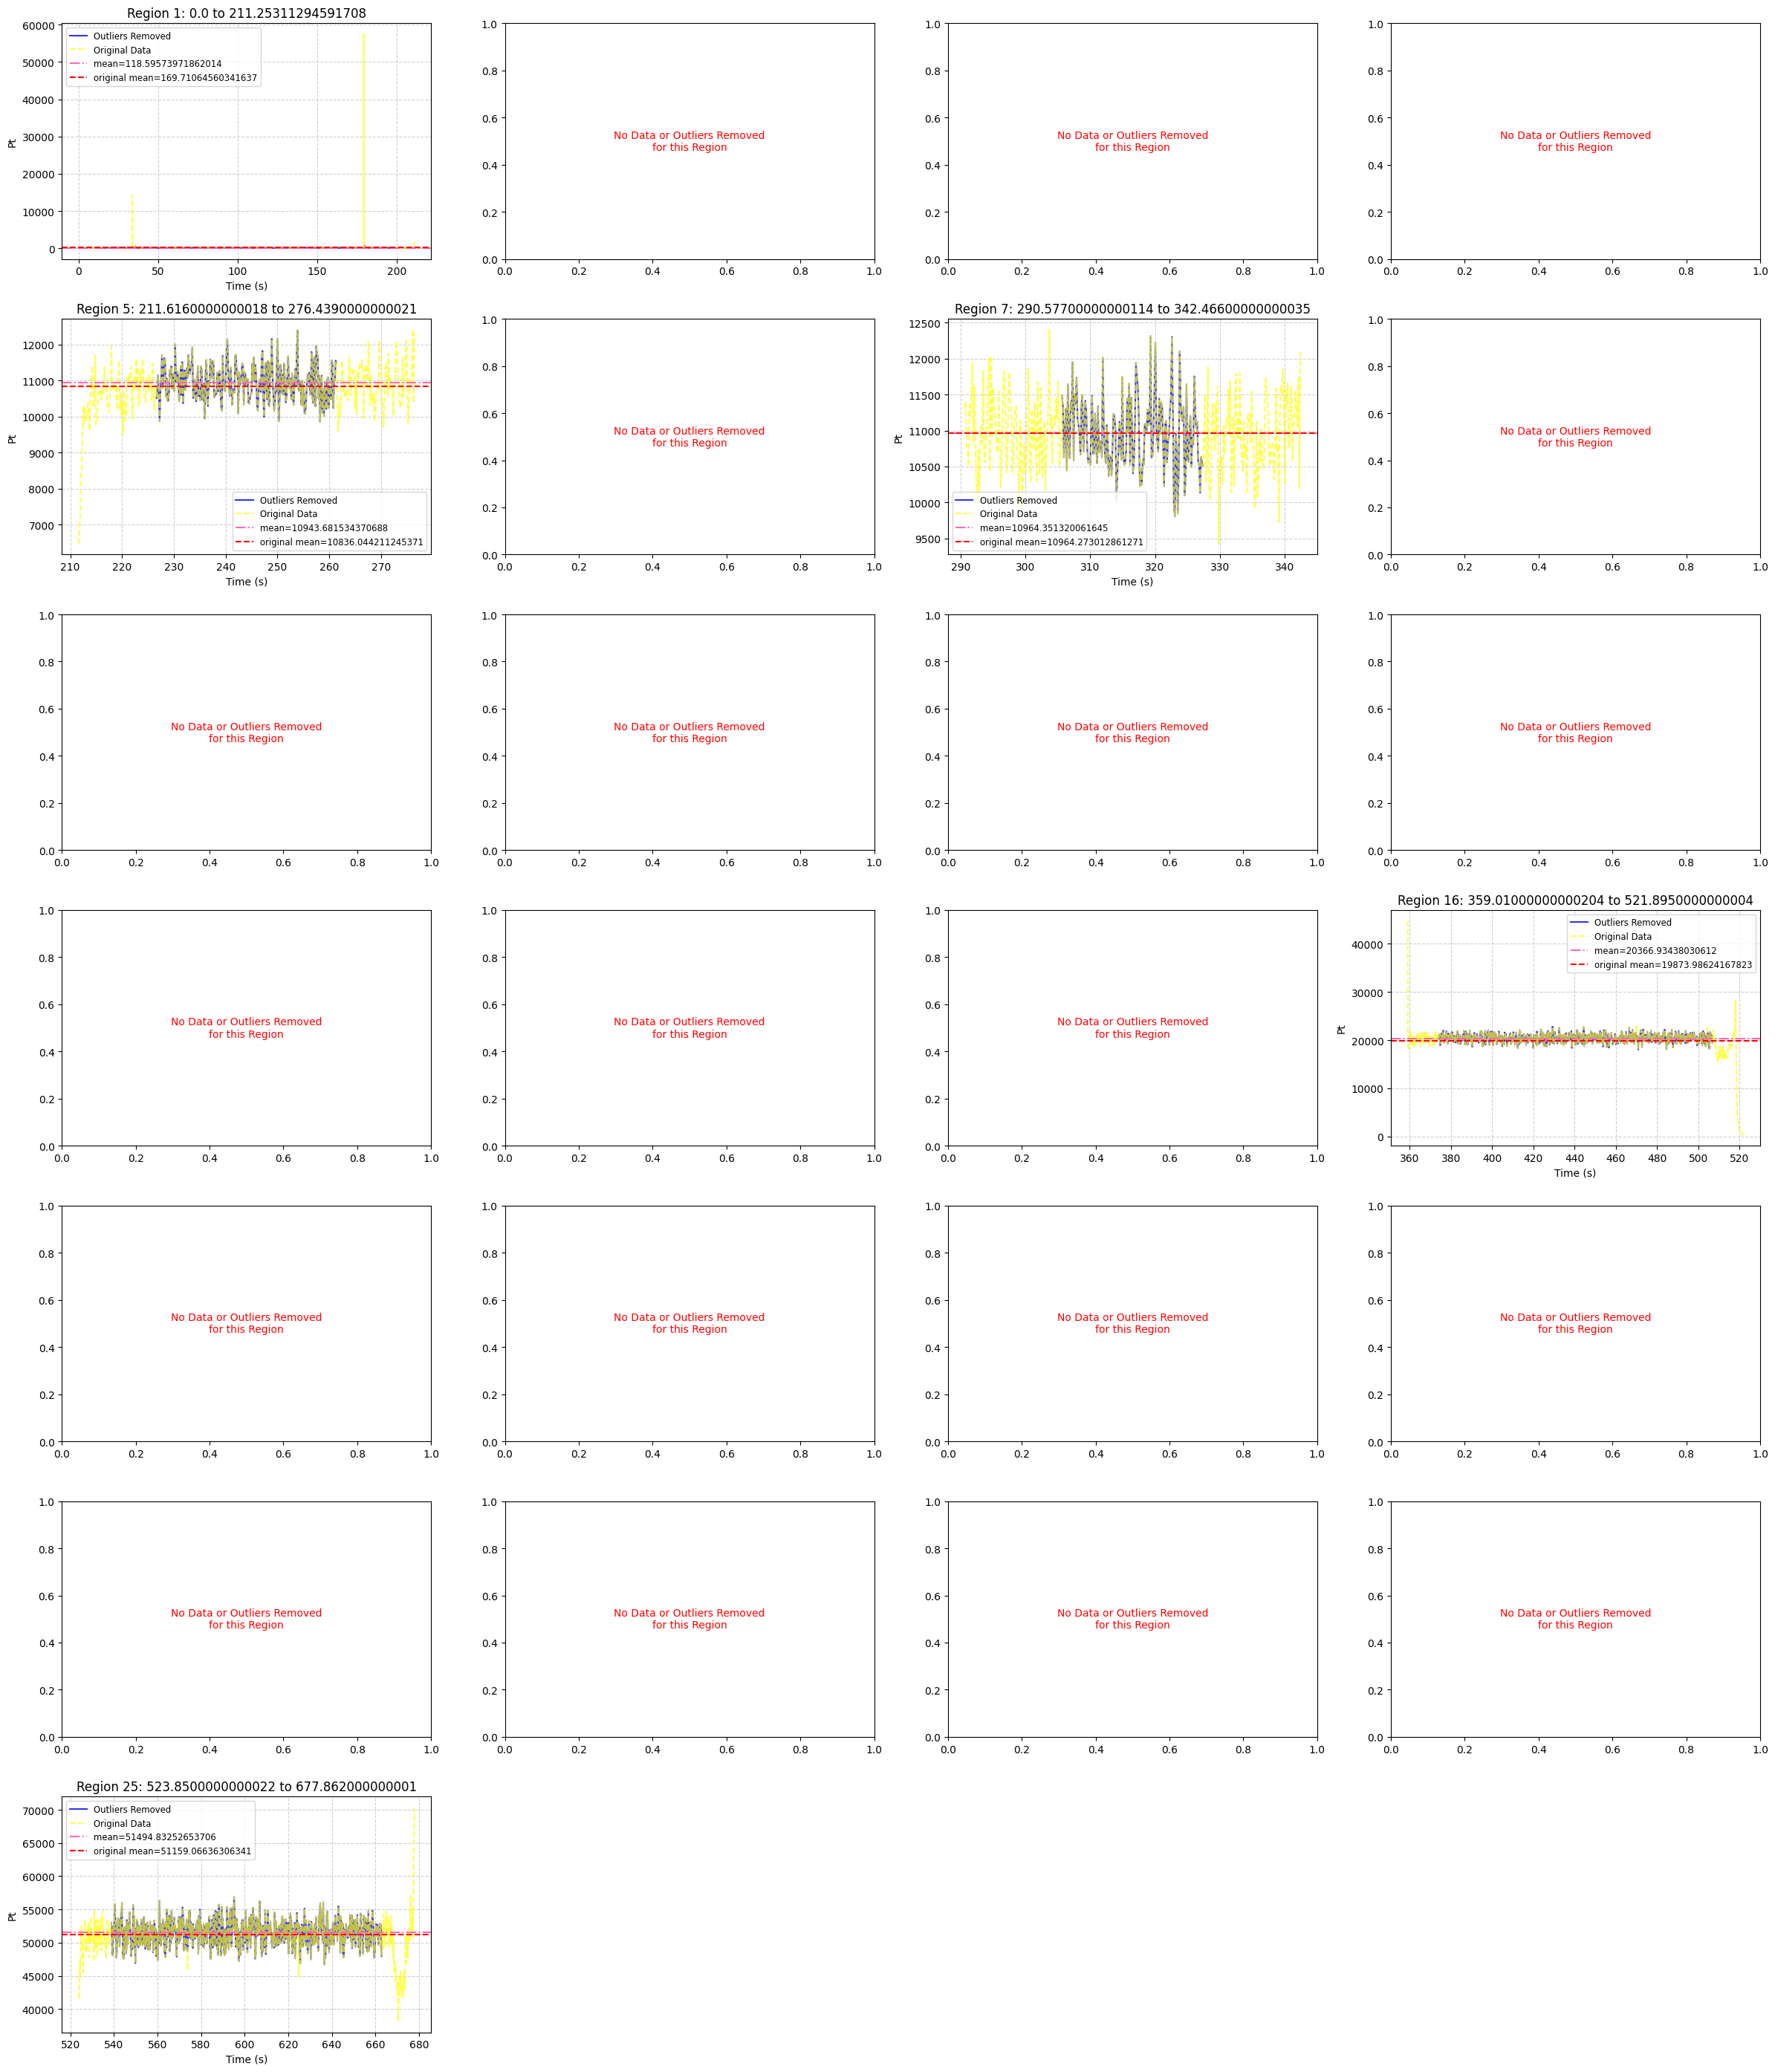

In [17]:
regional_means = []

num_regions = len(detected_intervals)
ncols = 4 # You can change the number of columns
nrows = (num_regions + ncols - 1) // ncols

offset = 15 # 15 seconds offset to 

final_df = pd.DataFrame()


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 4 * nrows))
axes_flat = axes.flatten() # Flatten the 2D axes array for easier iteration
for i, (x0, x1) in enumerate(detected_intervals):
    # Get the current Axes object for this iteration from the flattened array
    if i < len(axes_flat):
        current_ax = axes_flat[i]
    else:
        # This case should ideally not happen if nrows is calculated correctly,
        # but provides a safeguard if more plots are attempted than subplots available.
        logging.warning(f" Not enough subplots for region {i+1}. Skipping plot.")
        continue
    

    # Call your outlier removal function for the current region
    original_region_data = get_region(df=df, t0=x0, tf=x1)
    Y_prime = remove_outliers_by_region(R=(x0 + offset, x1 - offset), response_column_name=response, Y=df)

    # logging.info(f'New Region {i+1}: ({val['Start'] + offset}, {val['End'] - offset})')

    # Plot the results on the current subplot
    if not Y_prime.empty:
        # Plot the data after outlier removal
        current_ax.plot(Y_prime['Time'], Y_prime[response], label='Outliers Removed', color='blue', alpha=0.8)
        
        # Plot original data for comparison (only within the current region)

        
        current_ax.plot(original_region_data['Time'], original_region_data[response],
                        '--', color='yellow', alpha=0.7, label='Original Data')
        
        region_mean = Y_prime[response].mean()
        original_mean = original_region_data[response].mean()
        
        current_ax.axhline(y=region_mean, color='#FF69B4', linestyle='-.', label=f'mean={region_mean}')
        current_ax.axhline(y=original_mean, color='red', linestyle='--', label=f'original mean={original_mean}')

        regional_means.append(region_mean)
        
        current_ax.legend(fontsize='small')
    else:
        current_ax.text(0.5, 0.5, 'No Data or Outliers Removed\nfor this Region',
                        horizontalalignment='center', verticalalignment='center',
                        transform=current_ax.transAxes, fontsize=10, color='red')
        continue

    # Set titles and labels for the current subplot
    current_ax.set_title(f'Region {i+1}: {x0} to {x1}')
    current_ax.set_xlabel('Time (s)')
    current_ax.set_ylabel(f'{response}')
    current_ax.grid(True, linestyle='--', alpha=0.6) # Add a grid for better readability

    final_df = pd.concat([final_df, Y_prime], ignore_index=True)



# This prevents empty plots from appearing if your `area_df` has fewer regions than the grid size
for j in range(num_regions, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.savefig(f'{figure_dir}/regions.png',
             bbox_inches='tight',
             dpi=300)
plt.tight_layout() # Automatically adjust subplot parameters for a tight layout
plt.show() # Display the plot
    
# plt.tight_layout()
# plt.show()

In [18]:
final_df = final_df.sort_index()
final_df

,Time,Pt
0,15.041,50.000087
1,15.191,70.000171
2,15.341,110.000423
3,15.492,100.000350
4,15.642,100.000350
...,...,...
3281,662.220,51030.983140
3282,662.371,52345.727250
3283,662.521,52747.199900
3284,662.672,50448.921270


In [19]:
# Plot regional means
labels = np.array(concentrations)/10

data = pd.DataFrame(labels, regional_means)
display(data.index)
display(data.values)

Index([118.59573971862014, 10943.681534370688, 10964.351320061645,
        20366.93438030612,  51494.83252653706],
      dtype='float64')

array([[0.1],
       [0.2],
       [0.3],
       [0.4],
       [0.5]])

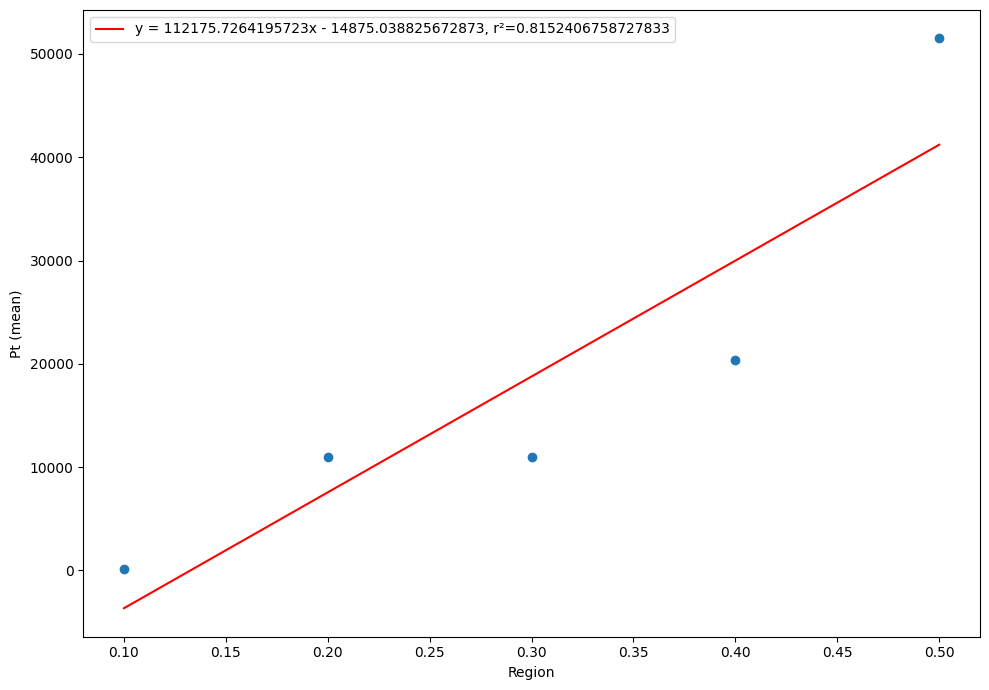

In [20]:
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot the bars
ax1.scatter(data.values, data.index)  # Convert index to string for proper label display
m,b = np.polyfit(labels, regional_means , 1)


model = LinearRegression()

X = labels.reshape(-1, 1)
y = np.array(regional_means)

model.fit(X,y)

r_squared = model.score(X,y)


# Find regression equation
if b >= 0:
    line_label = f'y = {m}x + {b}'
else:
    line_label = f'y = {m}x - {-b}' # Use -b to show a positive number after the minus sign

ax1.plot(labels, m*labels + b, color='red', label=f'{line_label}, r²={r_squared}')


plt.legend()

ax1.set_xlabel('Region')
ax1.set_ylabel(f'{response} (mean)')



plt.tight_layout()
plt.savefig(f'{figure_dir}/Regression-Plot.png', bbox_inches='tight',dpi=300)
plt.show()


$$ \textit{Opus ex amino, } \\ \text{Bhagawat Chapagain} $$